# Autoencoder Experiment Wrapper Test

Simple, step-by-step test of the experiment wrapper functionality.

## Test Plan:
1. Test basic imports
2. Test dataset generation
3. Test model creation
4. Test training
5. Verify results

Let's go through each step carefully...

In [1]:
# Step 1: Test imports
print("Step 1: Testing imports...")

# Basic imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Test autoencoder_lib imports one by one
try:
    from autoencoder_lib.experiment import ExperimentRunner
    print("✅ ExperimentRunner imported")
except Exception as e:
    print(f"❌ ExperimentRunner import failed: {e}")

try:
    from autoencoder_lib.models import MODEL_ARCHITECTURES, create_autoencoder
    print("✅ Models imported")
    print(f"   Available architectures: {list(MODEL_ARCHITECTURES.keys())}")
except Exception as e:
    print(f"❌ Models import failed: {e}")

try:
    from autoencoder_lib.data import generate_dataset
    print("✅ Data generation imported")
except Exception as e:
    print(f"❌ Data generation import failed: {e}")

print(f"\\nPyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print("\\n=== IMPORTS COMPLETE ===")

Step 1: Testing imports...
✅ ExperimentRunner imported
✅ Models imported
   Available architectures: ['simple_linear', 'deeper_linear', 'convolutional', 'deeper_convolutional']
✅ Data generation imported
\nPyTorch version: 2.7.0+cpu
Device: cpu
\n=== IMPORTS COMPLETE ===


Step 2: Testing dataset generation...


Generating variable_layers: 100%|██████████| 5/5 [00:00<00:00, 1000.12it/s]


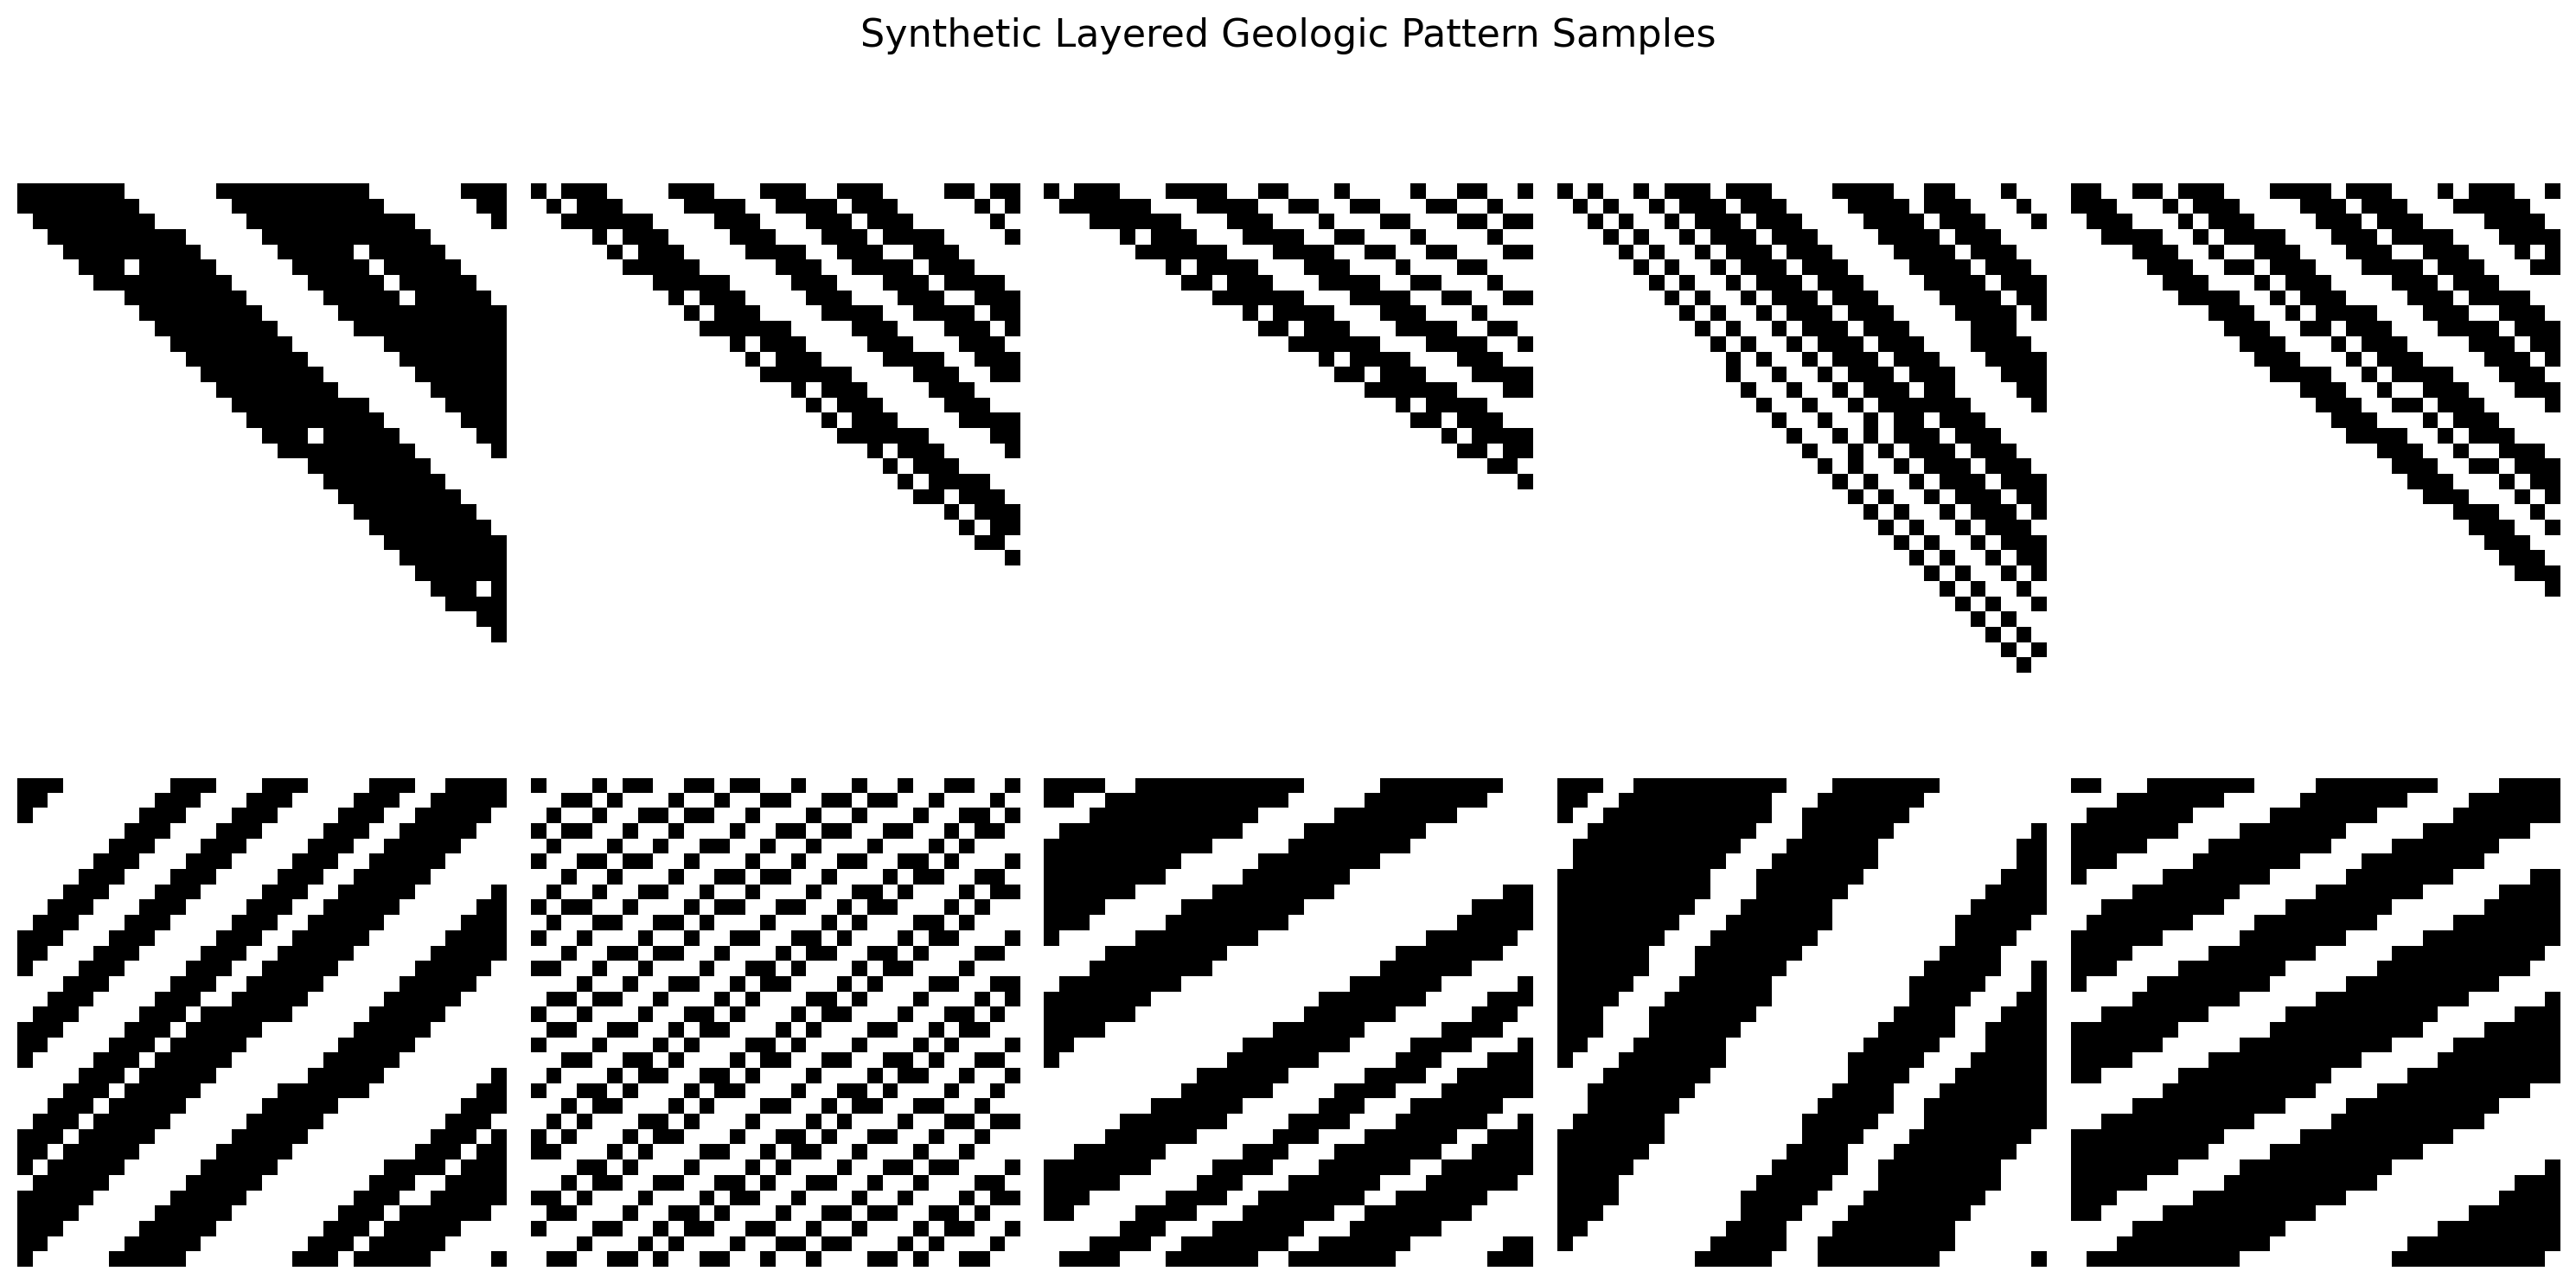


Dataset Statistics:
Total samples: 10
Number of classes: 2
Class distribution: {'consistent_layers': 5, 'variable_layers': 5}
Image size: 32x32

Train/Test Split Created:
Split seed: None
Train samples: 6 (70.0%)
Test samples: 2 (20.0%)
Validation samples: 2 (10.0%)
✅ Dataset generation successful!
   Dataset info keys: ['filenames', 'labels', 'label_names', 'params', 'split_info']
   Label names: ['consistent_layers', 'variable_layers']
   Output directory: simple_wrapper_test
   Created directories: ['consistent_layers', 'variable_layers']
   consistent_layers: 5 files
   variable_layers: 5 files
\n=== DATASET GENERATION COMPLETE ===


In [2]:
# Step 2: Test dataset generation
print("Step 2: Testing dataset generation...")

try:
    # Generate a small test dataset
    dataset_info = generate_dataset(
        dataset_type='layered_geological',
        output_dir='simple_wrapper_test',
        num_samples_per_class=5,  # Very small for testing
        image_size=32,
        num_classes=2
    )
    
    print("✅ Dataset generation successful!")
    print(f"   Dataset info keys: {list(dataset_info.keys())}")
    print(f"   Label names: {dataset_info.get('label_names', 'Not found')}")
    print(f"   Output directory: simple_wrapper_test")
    
    # Verify files were created
    test_dir = Path('simple_wrapper_test')
    if test_dir.exists():
        subdirs = [d for d in test_dir.iterdir() if d.is_dir()]
        print(f"   Created directories: {[d.name for d in subdirs]}")
        
        for subdir in subdirs:
            files = list(subdir.glob('*.png'))
            print(f"   {subdir.name}: {len(files)} files")
    
except Exception as e:
    print(f"❌ Dataset generation failed: {e}")
    import traceback
    traceback.print_exc()

print("\\n=== DATASET GENERATION COMPLETE ===")

In [5]:
# Step 3: Test model creation
print("Step 3: Testing model creation...")

# Test creating different model architectures
architectures_to_test = ['simple_linear', 'convolutional']

for arch in architectures_to_test:
    try:
        if arch == 'convolutional':
            model = create_autoencoder(
                architecture_name=arch,
                input_channels=1,  # Grayscale
                latent_dim=8
            )
        else:
            model = create_autoencoder(
                architecture_name=arch,
                input_size=32*32,  # 32x32 flattened
                latent_dim=8
            )
        
        print(f"✅ {arch}: {type(model).__name__} created")
        print(f"   Model: {model}")
        
    except Exception as e:
        print(f"❌ {arch} failed: {e}")

print("\\n=== MODEL CREATION COMPLETE ===")

Step 3: Testing model creation...
✅ simple_linear: SimpleLinearAutoencoder created
   Model: SimpleLinearAutoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1024, bias=True)
    (3): Sigmoid()
    (4): Unflatten(dim=1, unflattened_size=(1, 64, 64))
  )
)
✅ convolutional: ConvAutoencoder created
   Model: ConvAutoencoder(
  (conv_encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_encoder): Linear(in_features=4096, out_features

In [6]:
# Step 4: Load the generated dataset and prepare for training
print("Step 4: Loading dataset for training...")

from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

def load_simple_dataset(dataset_dir, class_names):
    """Load the generated dataset into tensors"""
    all_data = []
    all_labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = Path(dataset_dir) / class_name
        
        if class_dir.exists():
            for img_file in class_dir.glob("*.png"):
                # Load and convert image
                img = Image.open(img_file).convert('L')  # Grayscale
                img_array = np.array(img, dtype=np.float32) / 255.0
                all_data.append(img_array)
                all_labels.append(class_idx)
    
    # Convert to tensors
    data_tensor = torch.tensor(np.array(all_data), dtype=torch.float32).unsqueeze(1)
    labels_tensor = torch.tensor(all_labels, dtype=torch.long)
    
    return data_tensor, labels_tensor

try:
    # Load the dataset we generated
    class_names = dataset_info['label_names']
    data_tensor, labels_tensor = load_simple_dataset('simple_wrapper_test', class_names)
    
    print(f"✅ Dataset loaded successfully!")
    print(f"   Data shape: {data_tensor.shape}")
    print(f"   Labels shape: {labels_tensor.shape}")
    print(f"   Classes: {class_names}")
    print(f"   Label distribution: {torch.bincount(labels_tensor)}")
    
    # Split into train/test
    split_point = int(len(data_tensor) * 0.7)
    train_data = data_tensor[:split_point]
    train_labels = labels_tensor[:split_point]
    test_data = data_tensor[split_point:]
    test_labels = labels_tensor[split_point:]
    
    print(f"   Train samples: {len(train_data)}")
    print(f"   Test samples: {len(test_data)}")
    
    # Create DataLoader for training
    train_dataset = TensorDataset(train_data, train_data, train_labels)  # (input, target, labels)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    print(f"   Train loader created with {len(train_loader)} batches")
    
except Exception as e:
    print(f"❌ Dataset loading failed: {e}")
    import traceback
    traceback.print_exc()

print("\\n=== DATASET LOADING COMPLETE ===")

Step 4: Loading dataset for training...
✅ Dataset loaded successfully!
   Data shape: torch.Size([10, 1, 32, 32])
   Labels shape: torch.Size([10])
   Classes: ['consistent_layers', 'variable_layers']
   Label distribution: tensor([5, 5])
   Train samples: 7
   Test samples: 3
   Train loader created with 4 batches
\n=== DATASET LOADING COMPLETE ===


In [7]:
# Step 5: Test the ExperimentRunner directly
print("Step 5: Testing ExperimentRunner with a simple training run...")

try:
    # Create experiment runner
    runner = ExperimentRunner(
        output_dir="test_runner_output",
        random_seed=42
    )
    print("✅ ExperimentRunner created")
    
    # Create a simple model
    model = create_autoencoder(
        architecture_name='simple_linear',
        input_size=32*32,
        latent_dim=8
    )
    print("✅ Model created for training")
    
    # Run a very short training (just 1 epoch for testing)
    print("\\nStarting training (1 epoch for testing)...")
    trained_model, history = runner.train_autoencoder(
        model=model,
        train_loader=train_loader,
        test_data=test_data,
        test_labels=test_labels,
        epochs=1,  # Just 1 epoch for testing
        learning_rate=0.001,
        class_names=class_names,
        save_model=False,  # Don't save for testing
        experiment_name="simple_test"
    )
    
    print(f"\\n✅ Training completed successfully!")
    print(f"   History keys: {list(history.keys())}")
    print(f"   Final train loss: {history.get('final_train_loss', 'N/A')}")
    print(f"   Final test loss: {history.get('final_test_loss', 'N/A')}")
    print(f"   Training time: {history.get('training_time', 'N/A'):.2f}s")
    
except Exception as e:
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

print("\\n=== TRAINING TEST COMPLETE ===")

Step 5: Testing ExperimentRunner with a simple training run...
ExperimentRunner initialized - Device: cpu, Output: test_runner_output
✅ ExperimentRunner created
✅ Model created for training
\nStarting training (1 epoch for testing)...
Training SimpleLinearAutoencoder for 1 epochs on cpu
Learning rate: 0.001
Visualizing at epochs: [0]
❌ Training failed: unflatten: Provided sizes [1, 64, 64] don't multiply up to the size of dim 1 (1024) in the input tensor
\n=== TRAINING TEST COMPLETE ===


Traceback (most recent call last):
  File "C:\Users\cjh5690.PSU\AppData\Local\Temp\ipykernel_68644\2411263914.py", line 22, in <module>
    trained_model, history = runner.train_autoencoder(
  File "c:\PycharmProjects\AutoEncoder_Experimentation\autoencoder_lib\experiment\runner.py", line 284, in train_autoencoder
    encoded, decoded = model(b_x)
  File "c:\PycharmProjects\AutoEncoder_Experimentation\venv\lib\site-packages\torch\nn\modules\module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "c:\PycharmProjects\AutoEncoder_Experimentation\venv\lib\site-packages\torch\nn\modules\module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
  File "c:\PycharmProjects\AutoEncoder_Experimentation\autoencoder_lib\models\base.py", line 69, in forward
    decoded = self.decode(encoded)
  File "c:\PycharmProjects\AutoEncoder_Experimentation\autoencoder_lib\models\linear_autoencoders.py", line 54, in decode
    return self.decoder(z)
 

# Test Results Summary

If all the cells above ran successfully, you should see:

## ✅ Expected Results:
1. **Step 1**: All imports successful with available architectures listed
2. **Step 2**: Dataset generation creates 5 samples per class (10 total files)
3. **Step 3**: Both 'simple_linear' and 'convolutional' models created successfully
4. **Step 4**: Dataset loaded with proper shapes and train/test split
5. **Step 5**: Training completes in a few seconds with loss values

## 🎉 Success Indicators:
- No import errors
- Dataset files created in `simple_wrapper_test/` directory
- Model creation works for multiple architectures
- Training runs without errors and produces loss values
- All steps show ✅ checkmarks

## 🚨 If you see errors:
- Import errors → Check if autoencoder_lib is properly installed
- Dataset errors → Check file permissions and disk space
- Model errors → Check architecture parameters
- Training errors → Check data shapes and device compatibility

**This notebook tests the core functionality step-by-step to ensure everything works before building the full wrapper!**